In [7]:
# AlexNet

# 합성곱층 총 다섯개와 완전연결층 세개로 구성
# 맨마지막 완전연결층은 카테고리 1000개로 분류하기 위해 소프트맥스 활성화 함수 사용

In [8]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
nc = 2

class AlexNet(Sequential):
    
    def __init__(self, input_shape, nc):
        
        super().__init__()
        
        self.add(Conv2D(96, kernel_size = (11, 11), strides = 4, padding = 'valid', activation = 'relu',
                        input_shape = input_shape, kernel_initializer = 'he_normal'))
        self.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "valid", data_format = "channels_last"))
        
        self.add(Conv2D(256, kernel_size = (5, 5), strides = 1, padding = 'same', activation = 'relu',
                        kernel_initializer = 'he_normal')) # 가중치 초기화 방법으로 kernel_initializer 사용
        self.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "valid", data_format = "channels_last"))
        
        self.add(Conv2D(384, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu',
                        kernel_initializer = 'he_normal'))
        self.add(Conv2D(384, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu',
                        kernel_initializer = 'he_normal'))
        self.add(Conv2D(256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu',
                        kernel_initializer = 'he_normal'))
        
        self.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = "valid", data_format = "channels_last"))
        # data_format = 입력에 대한 형식 지정
        # channels_last -> 배치크기, 높이, 너비, 채널개수
        # channels_first -> 배치크기, 채널개수, 높이, 너비
        
        self.add(Flatten())
        self.add(Dense(4096, activation = 'relu'))
        self.add(Dense(4096, activation = 'relu'))
        self.add(Dense(1000, activation = 'relu'))
        self.add(Dense(nc, activation = 'softmax'))
        
        self.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
# fan in : 해당 계층에 들어오는 입력 텐서에 대한 차원의 크기
# fan out : 해당 계층이 출력하는 출력 텐서의 크기

# 가중치 초기화

# 확률분포 기반의 가중치 초기화 : 균일분포나 정규분호 등 특정한 확률분포에 기반하여 랜덤값 추출하여 가중치 초기화
# 분산 조정 기반의 초기화 
#     - LeCun 초기화 방식 : 입력값의 크기가 크면 클수록 초기화 값의 분산을 작게 만듬. (lecun_uniform / lecun_normal)
#     - Xavier 초기화 방식 : fan in과 fan out을 모두 고려하여 확률분포를 계산하고,
#                            LeCun 방식에서 2를 곱한 후 fan in과 fan out을 합한 크기로 나누어 준 값으로 확률분포를 조정
#                            ReLU를 활성화 함수로 할때는 잘 작동하지 않음. (glorot_uniform / glorot_normal)
#     - He 초기화 방식 : Xavier 방식에서 다시 fan out을 제거. fan in에 집중한 가중치. (he_uniform / he_normal)

In [18]:
input_shape = (100, 100, 3) 

md = AlexNet(input_shape, nc)
md.summary()

Model: "alex_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 256)         8

In [19]:
epochs = 100
batch = 32
img_h = 100
img_w = 100
t_dir = "./source/chap6/data/catanddog/train/"
v_dir = "./source/chap6/data/catanddog/validation/"

In [20]:
train = ImageDataGenerator(rescale = 1/255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.1,
                           shear_range = 0.1, zoom_range = 0.1)

train_g = train.flow_from_directory(t_dir, target_size = (img_h, img_w), color_mode = "rgb", batch_size = batch,
                                    seed = 1, shuffle = True, class_mode = "categorical")

valid = ImageDataGenerator(rescale = 1/255)

valid_g = valid.flow_from_directory(v_dir, target_size = (img_h, img_w), color_mode = "rgb", batch_size = batch,
                                    seed = 7, shuffle = True, class_mode = "categorical")

t_num = train_g.samples
v_num = valid_g.samples

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [21]:
log_dir = "./LOG/1114_2/"
tensor_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, profile_batch = 0)

md.fit(train_g, epochs = epochs, steps_per_epoch = t_num // batch, validation_data = valid_g, validation_steps = v_num // batch,
        callbacks = [tensor_callback], verbose = 1)

Epoch 1/100
12/12 [==============================] - 6s 475ms/step - loss: 14.6926 - accuracy: 0.5354 - val_loss: 0.6921 - val_accuracy: 0.5208
Epoch 2/100
12/12 [==============================] - 5s 458ms/step - loss: 0.6957 - accuracy: 0.5014 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/100
12/12 [==============================] - 6s 459ms/step - loss: 0.6958 - accuracy: 0.4788 - val_loss: 0.6928 - val_accuracy: 0.5104
Epoch 4/100
12/12 [==============================] - 6s 473ms/step - loss: 0.6938 - accuracy: 0.4896 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/100
12/12 [==============================] - 6s 459ms/step - loss: 0.6951 - accuracy: 0.5326 - val_loss: 0.6997 - val_accuracy: 0.4896
Epoch 6/100
12/12 [==============================] - 5s 456ms/step - loss: 0.6961 - accuracy: 0.4901 - val_loss: 0.6929 - val_accuracy: 0.5104
Epoch 7/100
12/12 [==============================] - 6s 480ms/step - loss: 0.6935 - accuracy: 0.5156 - val_loss: 0.6937 - val_accuracy: 0.489

Epoch 58/100
12/12 [==============================] - 6s 477ms/step - loss: 0.6926 - accuracy: 0.5184 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 59/100
12/12 [==============================] - 5s 456ms/step - loss: 0.6916 - accuracy: 0.5326 - val_loss: 0.6930 - val_accuracy: 0.5104
Epoch 60/100
12/12 [==============================] - 5s 454ms/step - loss: 0.6906 - accuracy: 0.5382 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 61/100
12/12 [==============================] - 5s 451ms/step - loss: 0.6910 - accuracy: 0.5326 - val_loss: 0.6958 - val_accuracy: 0.4896
Epoch 62/100
12/12 [==============================] - 6s 469ms/step - loss: 0.6919 - accuracy: 0.5241 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 63/100
12/12 [==============================] - 6s 477ms/step - loss: 0.6912 - accuracy: 0.5382 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 64/100
12/12 [==============================] - 5s 452ms/step - loss: 0.6925 - accuracy: 0.5184 - val_loss: 0.6931 - val_accuracy:

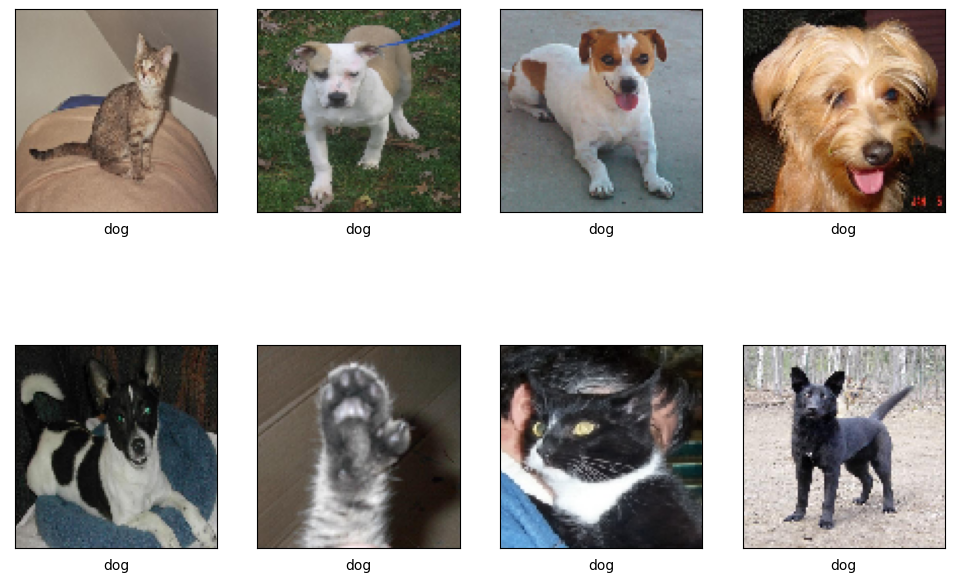

In [22]:
class_names = ['cat', 'dog']
validation, label_batch = next(iter(valid_g))
pred = md.predict(validation)
pred = np.argmax(pred, axis = 1)

pt.figure(figsize = (12, 8))

for i in range(8):
    
    pt.subplot(2, 4, i+1)
    pt.imshow(validation[i])
    pt.xticks(ticks = [])
    pt.yticks(ticks = [])
    
    pt.xlabel(class_names[pred[i]])